# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [1]:
# TODO: Make all necessary imports.
!pip install -q tqdm==4.28.1
# !pip install tensorflow-gpu
!pip install -q -U tensorflow_datasets

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
tfds.disable_progress_bar()

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

import time

import json

from PIL import Image

from tensorflow.keras.utils import load_img, img_to_array

from tensorflow.keras.preprocessing import image

# #anything that happens inside this loop will keep the workspace active
# from workspace_utils import keep_awake
from workspace_utils import keep_awake

print("All necessary packages imported successfully!")

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


2025-01-05 20:54:07.398686: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-05 20:54:07.398759: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-05 20:54:07.398806: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


All necessary packages imported successfully!


## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [2]:
# TODO: Load the dataset with TensorFlow Datasets.
dataset, dataset_info = tfds.load('oxford_flowers102', as_supervised=True, with_info=True)


# TODO: Create a training set, a validation set and a test set.
training_set = dataset['train']
test_set = dataset['test']
validation_set = dataset['validation']

print("dataset imported successfully!")

Dataset oxford_flowers102 downloaded and prepared to /home/student/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
dataset imported successfully!


2025-01-05 14:28:08.105380: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: UNKNOWN ERROR (34)


## Explore the Dataset

In [3]:
# TODO: Get the number of examples in each set from the dataset info.
num_training_examples = dataset_info.splits['train'].num_examples
num_test_examples = dataset_info.splits['test'].num_examples
num_validation_examples = dataset_info.splits['validation'].num_examples

print("\nThere are {:,} images in the training set".format(num_training_examples))
print("\nThere are {:,} images in the testing set".format(num_test_examples))
print("\nThere are {:,} images in the validation set".format(num_validation_examples))

print("\n>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
# TODO: Get the number of classes in the dataset from the dataset info.
num_classes = dataset_info.features['label'].num_classes
print("\nThere are {:,} classes in the data set".format(num_classes))


There are 1,020 images in the training set

There are 6,149 images in the testing set

There are 1,020 images in the validation set

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

There are 102 classes in the data set


In [4]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
for image, label in training_set.take(3):
    print("\nThe images in the training set have:")
    print("\u2022 dtype:", image.dtype)
    print("\u2022 shape:", image.shape)
    
    print("\nThe labels of the images have:")
    print("\u2022 dtype:", label.dtype)
    
    print("\n>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")


The images in the training set have:
• dtype: <dtype: 'uint8'>
• shape: (500, 667, 3)

The labels of the images have:
• dtype: <dtype: 'int64'>

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

The images in the training set have:
• dtype: <dtype: 'uint8'>
• shape: (500, 666, 3)

The labels of the images have:
• dtype: <dtype: 'int64'>

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

The images in the training set have:
• dtype: <dtype: 'uint8'>
• shape: (670, 500, 3)

The labels of the images have:
• dtype: <dtype: 'int64'>

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


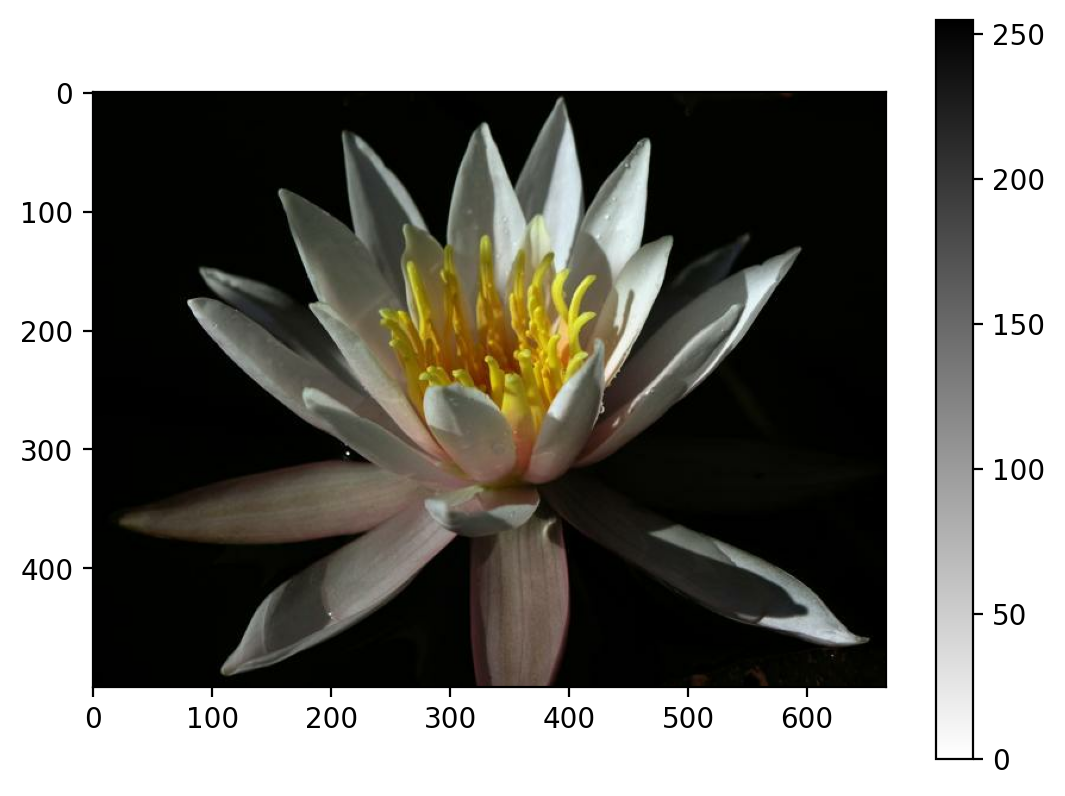

The label of this image is:  72


In [5]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding image label. 
for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.show()
print("The label of this image is: ", label)

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [6]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

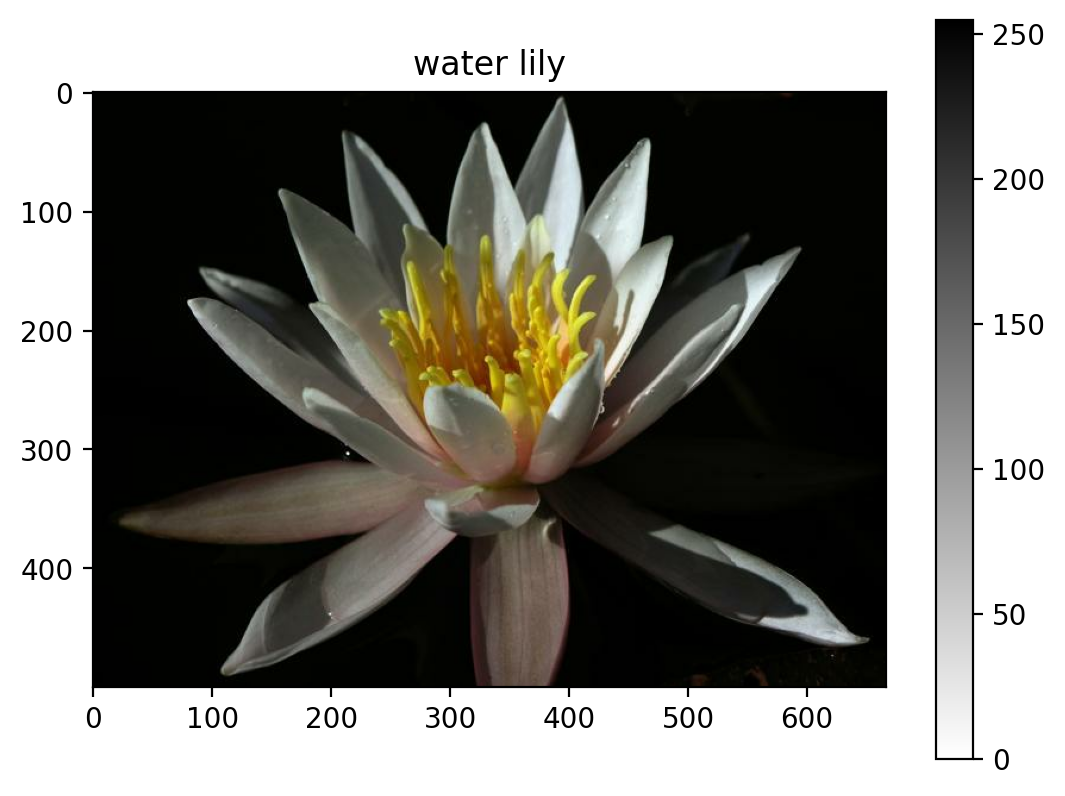

The label of this image is:  72 :  water lily


In [7]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
for image, label in training_set.take(1):
    class_name = class_names[str(label.numpy())]
    image = image.numpy().squeeze()

plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.title(class_name)
plt.show()
print("The label of this image is: ", label.numpy(), ": ", class_name)



In [7]:
BATCH_SIZE = 64
IMG_SHAPE = 224


In [8]:
#Function to resize images
def resize(image, label):
    # Resize all images to a fixed size (224, 224)
    image = tf.image.resize(image, [IMG_SHAPE, IMG_SHAPE])
    return image, label

#Function to normalize images
def normalize(image, label):
    #values to be between 0 and 1
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

## Create Pipeline

In [9]:
# Define ImageDataGenerator
# this function will be used to to some transoformation
#to the training_set images
#so then, these augumented images will be used to train the model
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    return image, label


In [10]:
# Apply resizing, normalization, and batching
#At first both resize and normalize functions were implemented under normalize function
#but the batch method could not be applied to images with different sizes and keep return an error related to that
#so, the resize function is applied at first, then the batch method, and finally the normalize function

training_set_original = (
    training_set
    .map(resize)
    .cache()
    .shuffle(num_training_examples//4)
    .batch(BATCH_SIZE)
    .map(normalize)
    .prefetch(tf.data.AUTOTUNE)
)

#train the model on training _set only was not sufficient
#in order to increase the model accuracy, multiple agumented datasets were created
#the model will be trained on a combined_training_batches, which include 
#the training_set_original
#the training_set1_augmented
#the training_set2_augmented

training_set1_augmented = (
    training_set
    .map(augment_image)
    .map(resize)
    .cache()
    .shuffle(num_training_examples//4)
    .batch(BATCH_SIZE)
    .map(normalize)
    .prefetch(tf.data.AUTOTUNE)
)

training_set2_augmented = (
    training_set
    .map(augment_image)
    .map(resize)
    .cache()
    .shuffle(num_training_examples//4)
    .batch(BATCH_SIZE)
    .map(normalize)
    .prefetch(tf.data.AUTOTUNE)
)

# Unbatch, combine, and rebatch
#combined_training_batches = training_set_original.unbatch().concatenate(training_set1_augmented.unbatch()).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


combined_training_batches = (
    training_set_original.unbatch()
    .concatenate(training_set1_augmented.unbatch())
    .concatenate(training_set2_augmented.unbatch())
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

for image_batch, label_batch in combined_training_batches.take(1):
    print("\u2022 dtype:", image_batch.dtype)
    print("\u2022 shape:", image_batch.shape)
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()

• dtype: <dtype: 'float32'>
• shape: (64, 224, 224, 3)


In [11]:
# Apply resizing, normalization, and batching
#At first both resize and normalize functions were implemented under normalize function
#but the batch method could not be applied to images with different sizes and keep return an error related to that
#so, the resize function is applied at first, then the batch method, and finally the normalize function

test_batches = (
    test_set
    .map(resize)
    .cache()
    .shuffle(num_test_examples//4)
    .batch(BATCH_SIZE)
    .map(normalize)
    .prefetch(1)
)
validation_batches = (
    validation_set
    .map(resize)
    .cache()
    .shuffle(num_validation_examples//4)
    .map(normalize)
    .batch(BATCH_SIZE)
    .prefetch(1)
)

• dtype: <dtype: 'float32'>
• shape: (64, 224, 224, 3)

There are a total of 64 image labels in this batch:
[ 60  77  38  54  26  39  73  86  24  92  91  90   8  39   3   5   3  39
  12  50  11  53  87  70  53  88   1  61   0  93  73  22  65  33  61  36
  40  55   3  46   3  34  98  20   8  65  70  58 101   2  41  35  90  51
  83  58  69  99   9  15  84  81  69  22]

----------


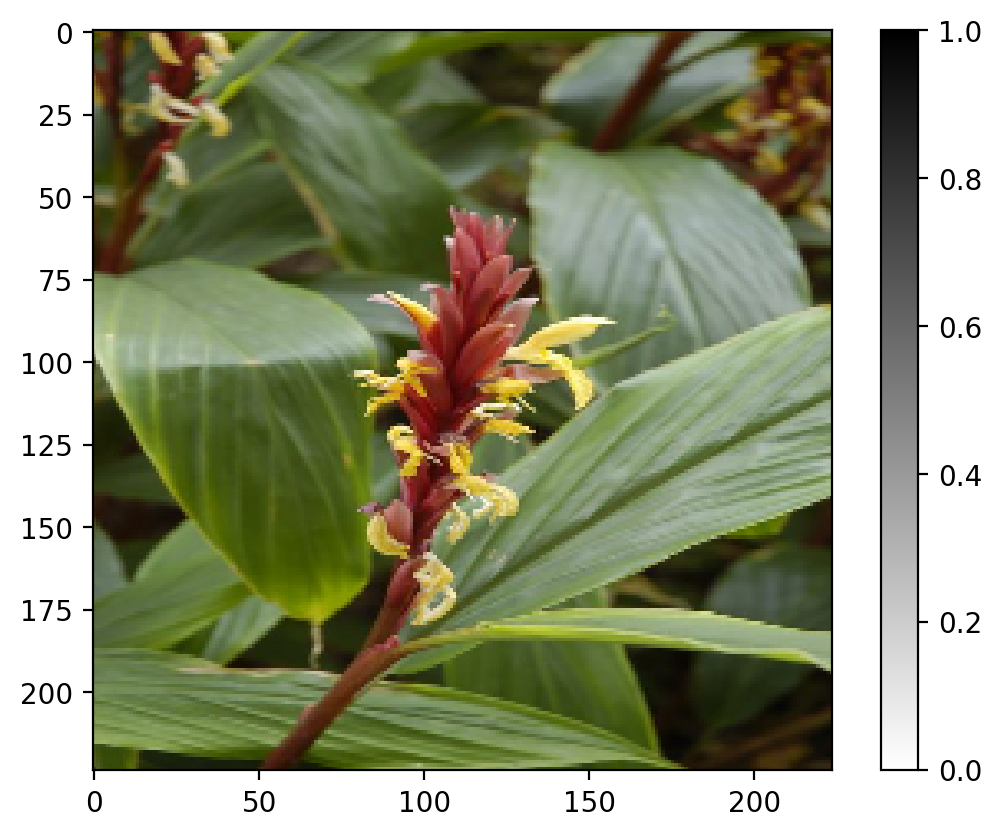

The label of this image is:  60 :  cautleya spicata


In [12]:
for image_batch, label_batch in combined_training_batches.take(1):
    print("\u2022 dtype:", image_batch.dtype)
    print("\u2022 shape:", image_batch.shape)
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()
    
    print("\nThere are a total of {} image labels in this batch:".format(label_batch.numpy().size))
    print(label_batch.numpy())
    print("\n----------")
    
plt.imshow(images[0], cmap = plt.cm.binary)
plt.colorbar()
plt.show()

print("The label of this image is: ", labels[0], ": ", class_names[str(labels[0])])

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [14]:
# TODO: Build and train your network.

#according to https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub
#the mobilenet url is:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

mobilenet = hub.KerasLayer(mobilenet_v2, input_shape=(IMG_SHAPE, IMG_SHAPE, 3), trainable=False)

layer_neurons = [1024, 512, 256, 128]

model = tf.keras.Sequential()
model.add(mobilenet)
model.add(
    tf.keras.layers
    .Flatten(input_shape = (IMG_SHAPE, IMG_SHAPE, 3))
)

for neurons in layer_neurons:
   model.add(tf.keras.layers.Dense(neurons, activation='relu')) 

model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
 flatten (Flatten)           (None, 1001)              0         
                                                                 
 dense (Dense)               (None, 1024)              1026048   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 102)               1

In [15]:
#compile the model
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [16]:
#before training
for image_batch, label_batch in combined_training_batches.take(1):
    loss, accuracy = model.evaluate(image_batch, label_batch)
print("Loss before training: {:,.3f}".format(loss))
print("Accuracy before training: {:,.3%}".format(accuracy))

2/2 [==============================] - 5s 2s/step - loss: 4.7897 - accuracy: 0.0000e+00
Loss before training: 4.790
Accuracy before training: 0.000%


In [17]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.

#Train the model

EPOCHS = 5

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
)

#Training the model on the combined_training_batches will take more time
#as the combined_training_batches contains
#the training_set_original
#the training_set1_augmented
#the training_set2_augmented
#and this will increase the accuracy for this model on testing_set
history = model.fit(
    combined_training_batches,
    epochs = EPOCHS,
    validation_data=validation_batches,
    callbacks=[early_stopping]
)
print(f"Training Completed")


Epoch 1/5
48/48 [==============================] - 287s 6s/step - loss: 2.6810 - accuracy: 0.3853 - val_loss: 1.7681 - val_accuracy: 0.5627
Epoch 2/5
48/48 [==============================] - 256s 5s/step - loss: 0.3731 - accuracy: 0.8977 - val_loss: 1.4078 - val_accuracy: 0.6520
Epoch 3/5
48/48 [==============================] - 265s 6s/step - loss: 0.1069 - accuracy: 0.9742 - val_loss: 1.4333 - val_accuracy: 0.6824
Epoch 4/5
48/48 [==============================] - 260s 5s/step - loss: 0.0371 - accuracy: 0.9928 - val_loss: 1.2596 - val_accuracy: 0.7265
Epoch 5/5
48/48 [==============================] - 255s 5s/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 1.2058 - val_accuracy: 0.7275
Training Completed


{'loss': [2.681002616882324, 0.37311655282974243, 0.1068987101316452, 0.03707569092512131, 0.0028901505284011364], 'accuracy': [0.385294109582901, 0.8977124094963074, 0.9741830229759216, 0.9928104281425476, 1.0], 'val_loss': [1.7680790424346924, 1.4077634811401367, 1.4332703351974487, 1.2595537900924683, 1.205848217010498], 'val_accuracy': [0.5627450942993164, 0.6519607901573181, 0.6823529601097107, 0.7264705896377563, 0.727450966835022]}


Text(0, 0.5, 'Accuracy')

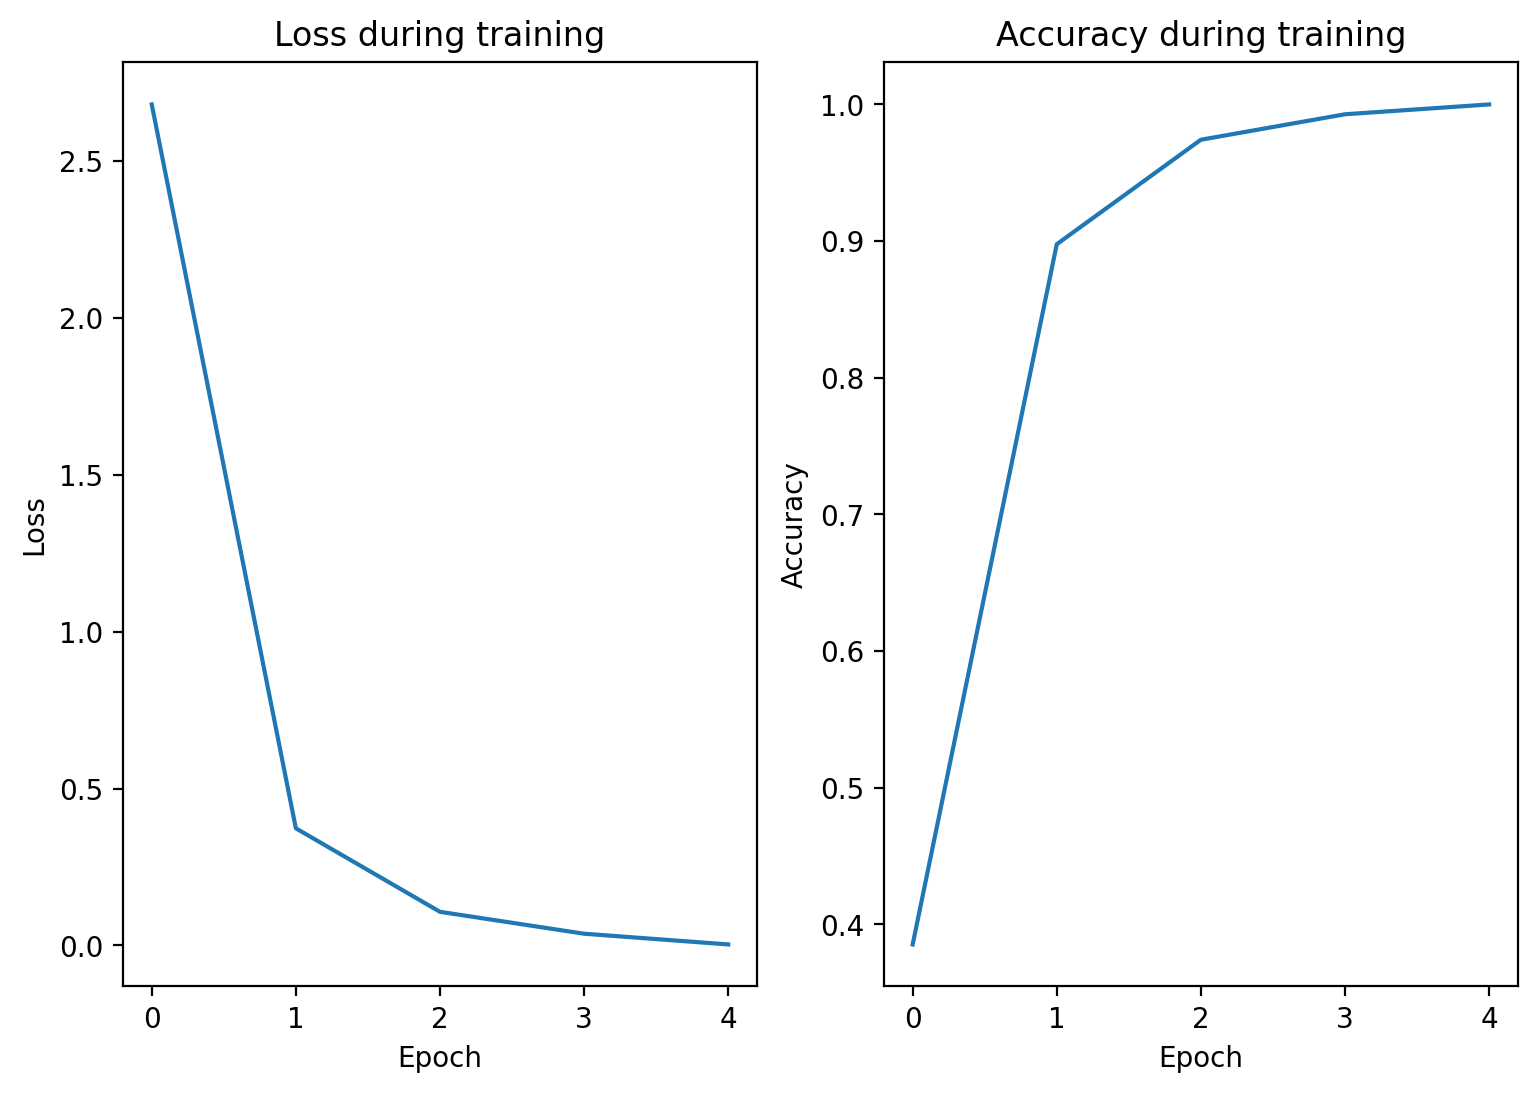

In [19]:
#Plot the loss and accuracy values achieved during training for the training and validation set.

#check the values in history.history to plot
print(history.history)

plt.subplots(figsize=(9,6), ncols=2)

#plot the loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Loss during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')

#plot the accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [ ]:
# TODO: Print the loss and accuracy values achieved on the entire test set.
for i in keep_awake(range(1), delay=20*60, interval=20*60):  # Increased delay and interval
    test_loss, test_accuracy = model.evaluate(test_batches)
    print(f"Test {i}: Completed")

print("Test Loss: {:,.3f}".format(test_loss))
print("Test Accuracy: {:,.3%}".format(test_accuracy))

## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [20]:
# TODO: Save your trained model as a Keras model.

t = time.time()
# save_keras_model_filepath = f'./flower102_classifier_last.keras'
save_keras_model_filepath = f'./flower102_classifier_mobilenet{int(t)}.keras'
model.save(save_keras_model_filepath)

# save_h5_model_filepath = f'./flower102_classifier_mobilenet{int(t)}.h5'
# model.save(save_h5_model_filepath)

print(f'The model has been sucessfully saved: {save_keras_model_filepath}')

The model has been sucessfully saved: ./flower102_classifier_last.keras


## Load the Keras Model

Load the Keras model you saved above.

In [16]:
# TODO: Load the Keras model
# save_keras_model_filepath = f'./flower102_classifier_last.keras'

!unzip -t {save_keras_model_filepath}

custom_objects = {'KerasLayer': hub.KerasLayer}

#path to a specific saved model
# save_keras_model_filepath = f'./flower102_classifier_mobilenet.keras'

# Load the model
reloaded_keras_model = load_model(
    save_keras_model_filepath,
    custom_objects=custom_objects
)

# Check the model summary
reloaded_keras_model.summary()

#getting error on loading the model by this command 'load model in not defined'
# reloded_keras_model = tf.keras.models.load_model(save_keras_model_filepath)
# reloded_keras_model.summary()

# np.testing.assert_allclose(
#     model.predict(testing_batches), reloaded_h5_model.predict(testing_batches)
# )


Archive:  ./flower102_classifier_last.keras
    testing: metadata.json            OK
    testing: config.json              OK
    testing: model.weights.h5         OK
No errors detected in compressed data of ./flower102_classifier_last.keras.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
 flatten (Flatten)           (None, 1001)              0         
                                                                 
 dense (Dense)               (None, 1024)              1026048   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
           

# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [17]:
# TODO: Create the process_image function
def process_image(image):
    # Convert the NumPy array to a TensorFlow tensor
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    
    # Resize the image to (224, 224)
    image_tensor = tf.image.resize(image_tensor, (IMG_SHAPE, IMG_SHAPE))
    
    # Normalize the pixel values to [0, 1]
    image_tensor = image_tensor / 255.0
    
    return image_tensor.numpy() 


To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

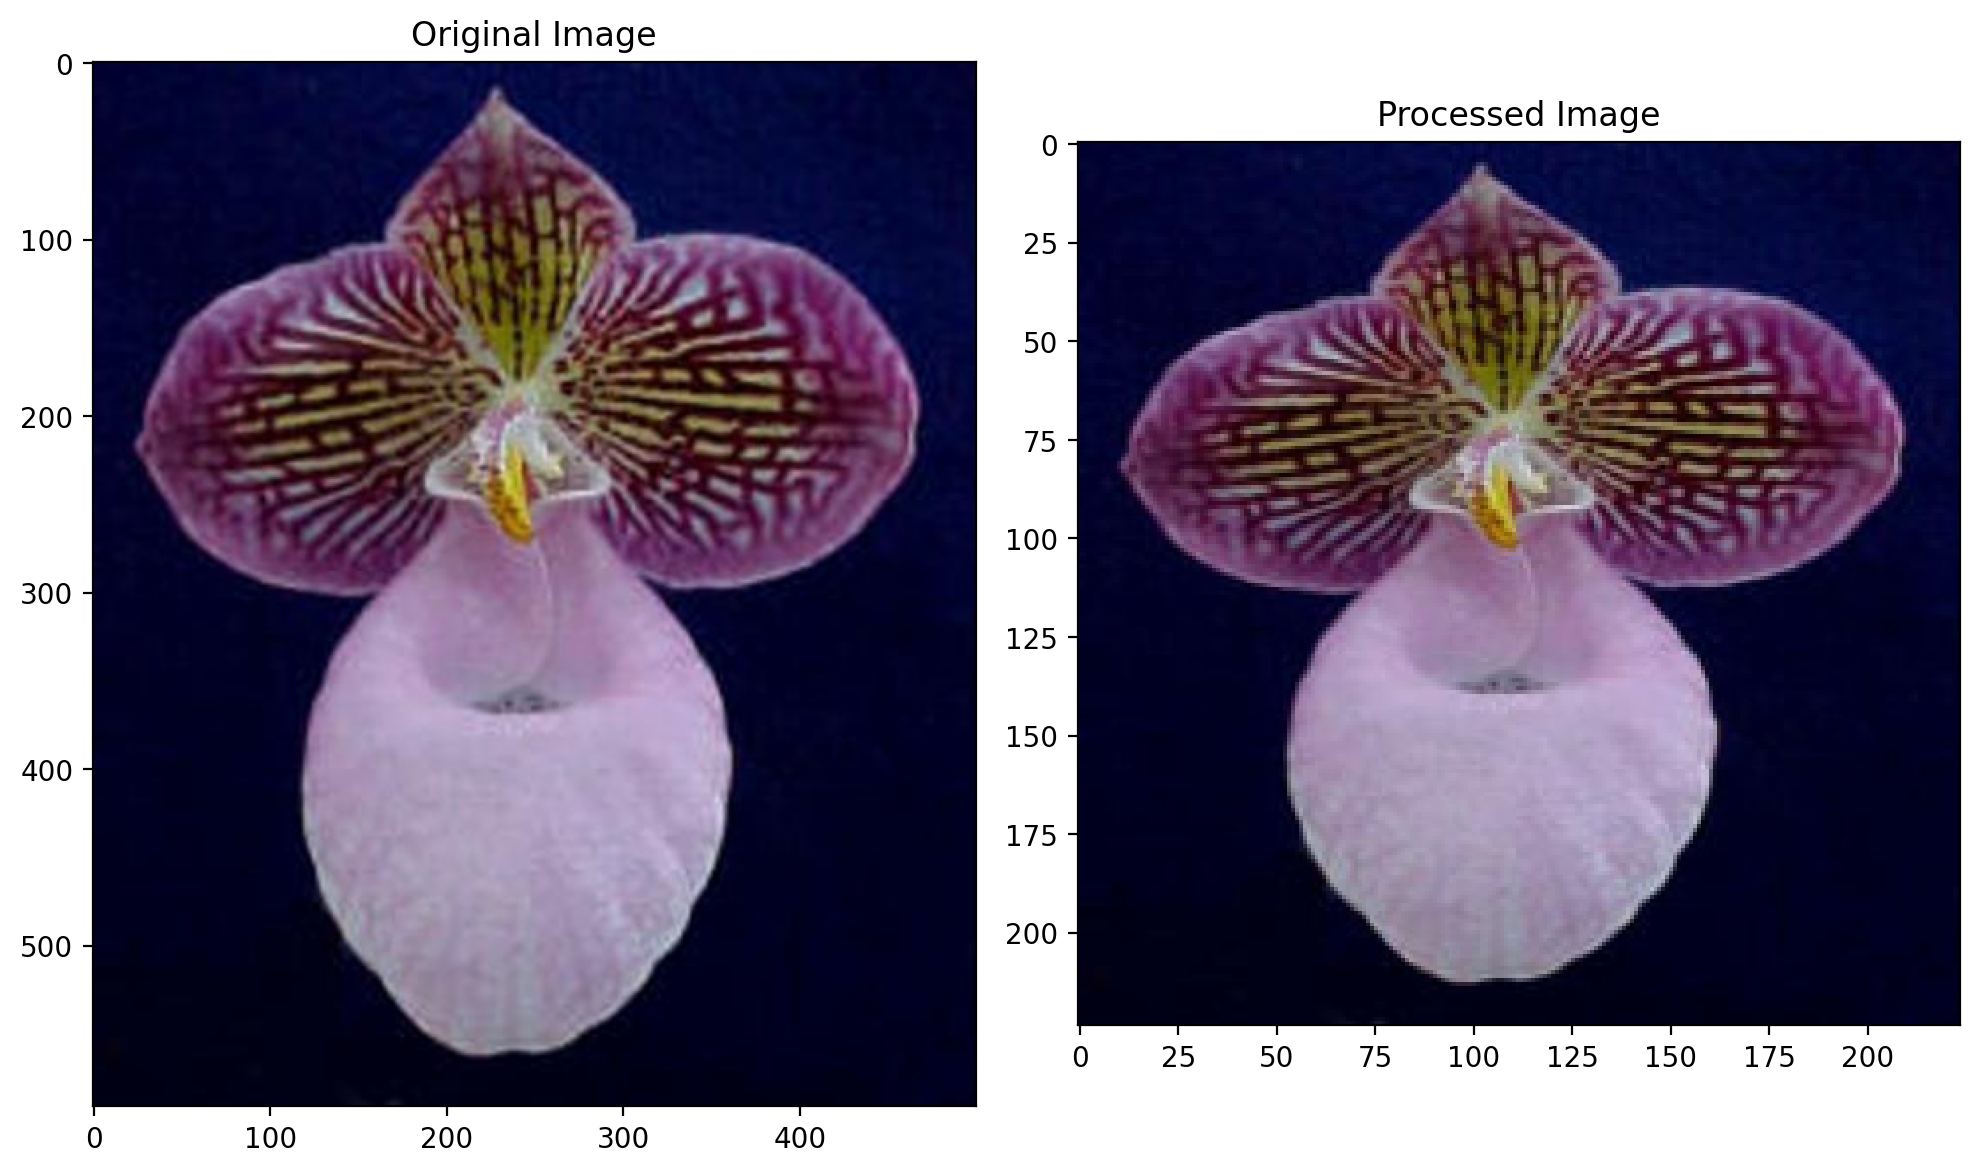

In [18]:
test_image_paths = [
    './test_images/cautleya_spicata.jpg',
    './test_images/hard-leaved_pocket_orchid.jpg',
    './test_images/orange_dahlia.jpg',
    './test_images/wild_pansy.jpg'
]

image_path = test_image_paths[1]
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [19]:
# TODO: Create the predict function

#I found that when reloading a previous model the model variable name
#may be changed (model or reloaded_keras_model)
#to prevent any errors, the 'try' will be used
try:
    # Check if 'model' is already defined
    model
except NameError:
     # Assign 'reloaded_keras_model' if 'model' is not defined
    model = reloaded_keras_model
else:
    model = model or reloaded_keras_model

# Function to load and preprocess an image
def load_and_preprocess_image(img_path):
    img = load_img(img_path, target_size=(IMG_SHAPE, IMG_SHAPE))  # Resize to match input size
    img_array = img_to_array(img)  # Convert to numpy array
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image
    return img_array
    
#Create the predict function   
def predict(image_path, model, top_k):
    img_array = load_and_preprocess_image(image_path)

    # Make prediction
    predictions = model.predict(img_array)
    
    # Get the top k predictions (probabilities and corresponding classes)
    top_k_probs, top_k_classes = tf.math.top_k(predictions[0], k=top_k)
    return top_k_probs.numpy(), top_k_classes.numpy()
    


In [20]:
# Number of top predictions to retrieve
top_k = 5

probs, classes = predict(image_path, model, top_k)

# Print the top k probabilities and class labels
print("Top K Probabilities:", probs)
print("Top K Classes:", classes)

# Extract class names from the dataset info
class_names = dataset_info.features['label'].names  
# Convert class indices to class names
class_names_predicted = [class_names[int(i)] for i in classes.flatten()]
print("Top K Class Names:", class_names_predicted)

1/1 [==============================] - 0s 453ms/step
Top K Probabilities: [9.9995625e-01 3.7804100e-05 2.8186412e-06 1.0759932e-06 1.0263468e-06]
Top K Classes: [ 1 67 22  5 93]
Top K Class Names: ['hard-leaved pocket orchid', 'bearded iris', 'fritillary', 'tiger lily', 'foxglove']


# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

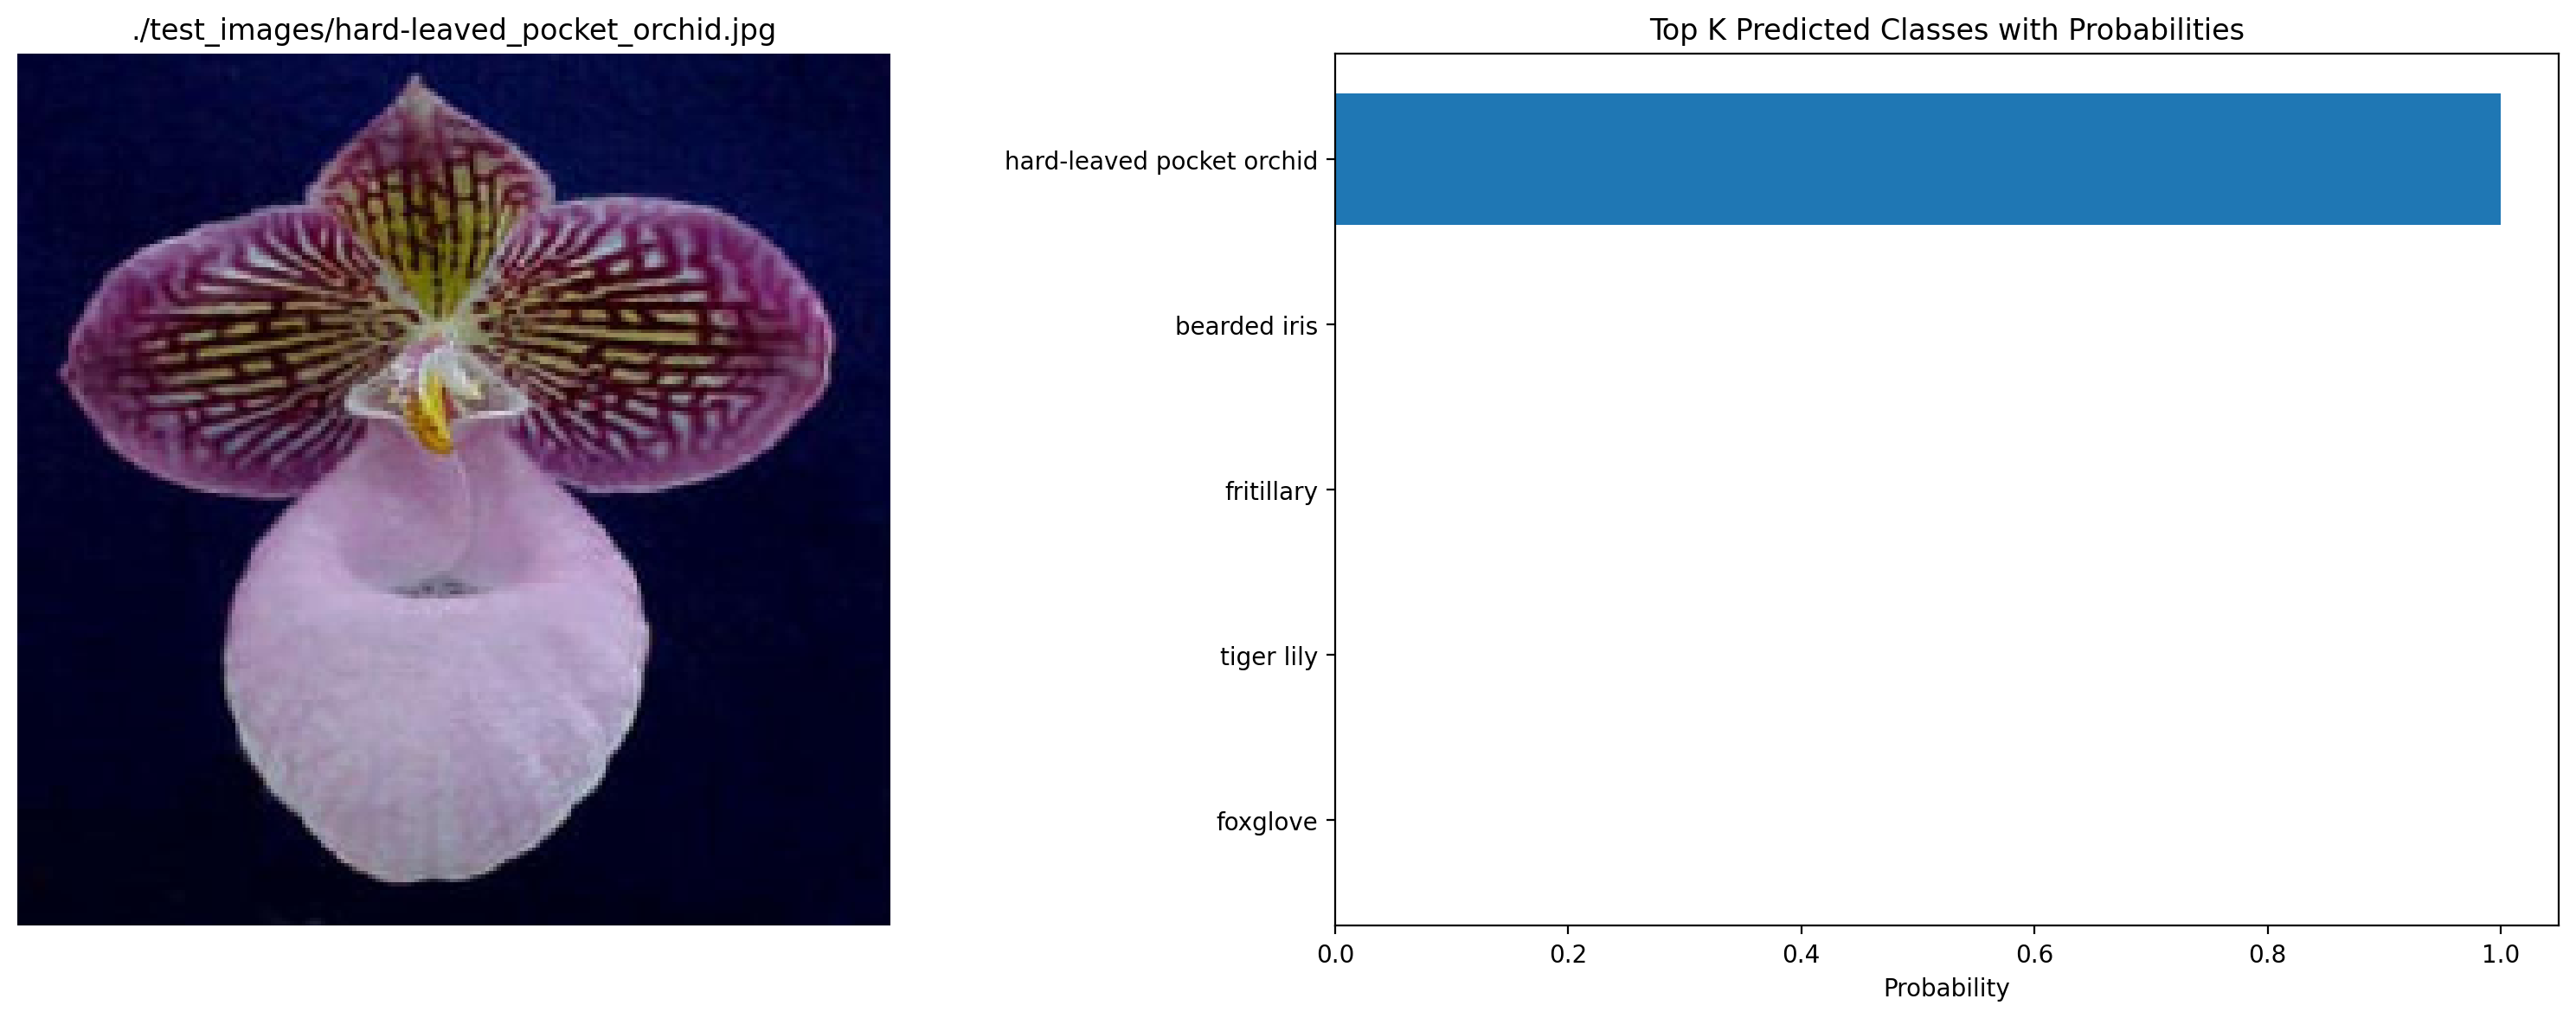

In [21]:
# TODO: Plot the input image along with the top 5 classes

# Plotting side by side
plt.figure(figsize=(16, 6))

# Plotting the input image in the first subplot (1 row, 2 columns, position 1)
plt.subplot(1, 2, 1)
img = image.load_img(image_path, target_size=(224, 224))
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.title(image_path)

# Plotting the top k classes and probabilities in the second subplot (1 row, 2 columns, position 2)
plt.subplot(1, 2, 2)
plt.barh(range(top_k), probs.flatten(), align='center')
plt.yticks(range(top_k), class_names_predicted)  # Use class names instead of indices
plt.xlabel('Probability')
plt.title('Top K Predicted Classes with Probabilities')
plt.gca().invert_yaxis()  # Reverse the order for better readability

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()